# $t_\pi$ Rabi Measurements

***Collin Bradford***

This example code runs a scan to find $t_\pi$, which is the pulse length that is required to take the qubit from a ground state to an excited state. To accomplish this test, a pulse of varying length is sent to the qubit at the qubit frequency. Immediately after, a readout pulse is sent to the cavity and the cavity transmission is measured. When the qubit transitions from a ground state to an excited state, the resonant frequency fo the cavity will change and the transmission will drop. When the cavity transmission is at its lowest, the qubit is in the excited state. The pulse time required to put the cavity transmission in the lowest state is the pulse time required to bring the qubit from the ground to an excited state, or a $t_\pi$ pulse. f

### ASM

The ASM program is designed to perform most of the work for the $t_\pi$ rabi measurement. The ASM program has two loops. The first runs through various amounts of time for the $t$ pulse. A variable, $\Delta t$ or `deltaTime` stored in p.0 r.5 defines the number of clocks or amount of time to be added each iteration of the loop. As the loop progresses, the $t$ pulse becomes longer and longer. 

The inner loop defines how many times the experiment is run for a given value of $t$. A variable, `loopCount` stored in p.1 r.2, defines how many times the inner loop runs. 

### Python

The python portion really just sets the registers and reads out the information when it is available. 

### Address Space

* 1: Frequency for the qubit channel 
* 2: Start gain for the qubit channel
* 3: Delta gain for the qubit channel
* 4: Start time duration for the qubit excitation pulse
* 5: Delta time for the qubit excitation pulse
* 6: Frequency for the cavity channel
* 7: Gain for the cavity channel
* 8: Time duration for the cavity readout pulse
* 9: Outer loop count
* 10: Inner loop count
* 11: Relaxation time duration for the relaxation time given after a readout pulse

### Register Space

* Page 0:
    * 1: Frequency for the qubit channel
    * 2: Start/current gain for the qubit channel
    * 3: Delta gain for the qubit channel
    * 4: Start time duration for the qubit excitation pulse
    * 5: Delta time for the qubit excitation pulse
    * 6: Frequency for the cavity channel
    * 7: Gain for the cavity channel
    * 8: Time duration for the cavity readout pulse
    * 9: Output settings for the qubit pulse channel
    * 10: Combined output settings + pulse duration value for the qubit channel
    * 11: Output settings + pulse duration for cavity channel (Since this does not change, we only use one register)
    * 12: Relaxation time duration
* Page 2:
    * 1: Outer loop count
    * 2: Inner loop count
    * 3: Output trigger enable. This is written to output 0 to enable the external trigger and the readout block. It is written during the cavity readout pulse. 
    * 4: Inner loop current itteration. Because the inner loop runs multiple times, a separate register must be used to hold the loop value. This value will be reset to the value in p1r2 before each iteration of the inner loop. 

In [9]:
#Program Variables

qubitOutputChannel = 1 #1 - 7
cavityOutputChannel = 2 #1 - 7
inputChannel = 0 #0 or 1

qubitFrequency = 100 #MHz
qubitStartGain = 20000
qubitDeltaGain = 1000
qubitStartTimeNS = 0 #anoseconds
qubitDeltaTimeNS = 2.6 #nanoseconds

cavityFrequency = 1000 #MHz
cavityGain = 10000

readoutPulseDurationNS = 100 #nanoseconds
relaxationTimeNS = 100 #nanoseconds

outerLoopCount = 100
innerLoopCount = 10

clockPeriodNS = 2.6 #nanoseconds

In [10]:
#Imports

import matplotlib.pyplot as plt

from pynq import Overlay
import numpy as np

from qsystem_2 import *
from qsystem2_asm import *

In [11]:
#Load the bitfile

soc = PfbSoc('qsystem_2.bit', force_init_clks=False)

In [12]:
#ASM 
with ASM_Program() as p:
    #Write all memory addresses to program memory
    #Set the frequency for the qubit channel 
    p.memri(0, 1, 1,"freq qubit channel")
    #Set the start gain and delta gain for the qubit channel
    p.memri(0, 2, 2,"start/current gain qubit channel")
    p.memri(0, 3, 3,"delta gain qubit channel")
    #Set the start time adn delta time for the qubit excitation pulse
    p.memri(0, 4, 4,"start/current time qubit excitation pulse")
    p.memri(0, 5, 5,"delta time for qubit excitation pulse")
    #Set the frequency, gain, and time for the cavity readout pulse
    p.memri(0, 6, 6,"Freuqency for cavity readount pulse")
    p.memri(0, 7, 7,"Gain for cavity readount pulse")
    p.memri(0, 8, 8,"Time duration for cavity readout pulse")
    #Set the relaxation time
    p.memri(0, 12, 11,"Relaxation time")
    #Set the outer and inner loop count registers
    p.memri(1, 1, 9,"Outer loop count")
    p.memri(1, 2, 10,"Inner loop count")
    #Trigger value for the average block. This will be enabled during the cavity readout pulse
    p.regwi(1,3, 0x4001 if inputChannel == 0 else 0x8001)
    #Set up the DAC selection and pulse duration register for the qubit channel
    p.regwi(0,9,0b1001,"0b1001, stdysel = 1 (zero value), mode = 0 (nsamp), outsel = 01 (dds).") #Value
    p.bitwi(0,9,9, "<<", 16) #Shift it left and leave it in r9
    p.bitw(0,10,2,"|",9) #Combine the settings into register 10. We use a different register so that we can combine values in fewer steps later when the pulse duration changes. 
    #Set up the DAC Selection and pulse duration register for the cavity channel. We use the same ouptut select because it is the same for both channels. Only the pusle duration is different for this register. 
    p.bitw(0,11,8,"|",9)
    #Delay the start a bit
    p.synci(1000)
    #Loop
    p.label("OUTER_LOOP")
    #Reset the inner loop count
    p.math(1,4,0,"+",2) #Set the current inner loop count to the contents 
    p.label("INNER_LOOP")
    #Que the qubit pulse immediately and que all later operations after it finishes
    p.set(qubitOutputChannel,0,1,0,0,2,10,0)
    p.sync(0,4)
    #Que the readout pulse right after the qubit pulse, start the trigger, and que all later operations after it finishes
    p.set(cavityOutputChannel,0,6,0,0,7,11,0)
    p.seti(0,1,3,0)
    p.sync(0,8)
    #Delay for the relaxation time
    p.sync(0,12)
    #Disable the trigger
    p.seti(0,1,0,0)
    p.loopnz(1,4,"INNER_LOOP")
    #Run the math to add the gain values and time delay values for the next iteration of the inner loop. 
    p.math(0,2,2,"+",3) #Add delta gain to the current gain and store it in the current gain register. 
    p.math(0,4,4,"+",5) #Add delta time to the current time and store it in the current time register. 
    p.loopnz(1,1,"OUTER_LOOP")
    #End the signal
    p.seti(0,0,0,0)
soc.tproc.load_asm_program(p)

In [14]:
#Python code

def timeToClocks(nanoseconds):
    return int(nanoseconds / clockPeriodNS)

def rabiMeasurement(qFreq=qubitFrequency,
                   cavFreq=cavityFrequency,
                   qsGain=qubitStartGain,
                   qdGain=qubitDeltaGain,
                   qsTimeNS=qubitStartTimeNS,
                   qdTimeNS=qubitDeltaTimeNS,
                   cavGain=cavityGain,
                   readoutPulseDurationNS=readoutPulseDurationNS,
                   relaxationTimeNS=relaxationTimeNS,
                   outerLoopCount=outerLoopCount,
                   innerLoopCount=innerLoopCount):
    
    #Populate the address space. 
    qFreqReg = freq2reg(soc.fs_dac, qFreq, B=32)
    soc.tproc.single_write(addr=1, data=qFreqReg)
    
    soc.tproc.single_write(addr=2, data=qsGain)
    soc.tproc.single_write(addr=3, data=qdGain)
    
    qsTimeClocks = timeToClocks(qsTimeNS)
    soc.tproc.single_write(addr=4, data=qsTimeClocks)
    qdTimeClocks = timeToClocks(qdTimeNS)
    soc.tproc.single_write(addr=5, data=qdTimeClocks)
    
    cavFreqReg = freq2reg(soc.fs_dac, cavFreq, B=32)
    soc.tproc.single_write(addr=6, data=cavFreqReg)
    soc.tproc.single_write(addr=7, data=cavGain)
    readoutPulseDurationClocks = timeToClocks(readoutPulseDurationNS)
    soc.tproc.single_write(addr=8, data=readoutPulseDurationClocks)
    
    soc.tproc.single_write(addr=9, data=outerLoopCount)
    soc.tproc.single_write(addr=10, data=innerLoopCount)
    
    relaxationTimeClocks = timeToClocks(relaxationTimeNS)
    soc.tproc.single_write(addr=11, data=relaxationTimeClocks)
    
    decimatedLength = readoutPulseDurationClocks
    accumulatedLength = outerLoopCount * innerLoopCount
    
    #Set up the readout buffer
    soc.readouts[inputChannel].set_out("product")
    soc.readouts[inputChannel].set_freq(cavFreq)
    soc.avg_bufs[inputChannel].config(address=inputChannel, length=decimatedLength)
    soc.avg_bufs[inputChannel].enable()
    
    #Start tProc
    #soc.setSelection("product")
    soc.tproc.stop()
    soc.tproc.start()
    
    time.sleep(1)
    
    idec,qdec = soc.get_decimated(ch=inputChannel)
    iacc,qacc = soc.get_accumulated(ch=inputChannel, length=accumulatedLength)
    
    return idec, qdec, iacc, qacc

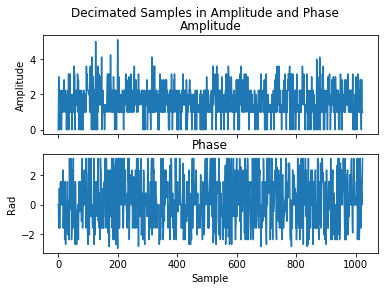

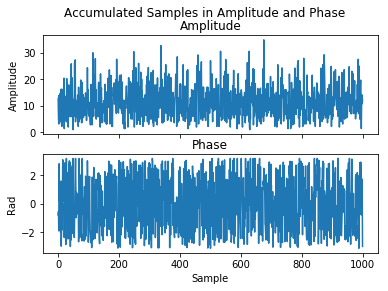

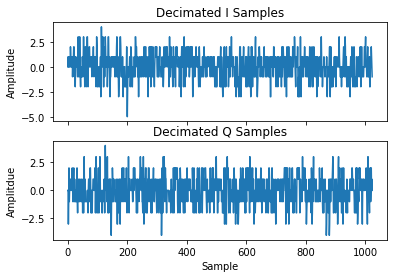

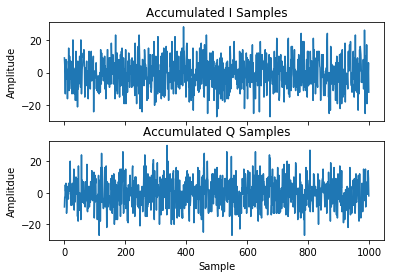

In [15]:
#Receive Information from the rabi measurement defined at the top of the file. 

idec,qdec,iacc,qacc = rabiMeasurement()

decMagnitudes = np.abs(idec + 1j * qdec)
decPhases = np.angle(idec + 1j * qdec)

accMagnitudes = np.abs(iacc + 1j * qacc)
accPhases = np.angle(iacc + 1j * qacc)

fig,ax = plt.subplots(2,1,sharex=True)
plt.suptitle("Decimated Samples in Amplitude and Phase")
ax[0].plot(decMagnitudes)
ax[0].set_title("Amplitude")
ax[0].set_ylabel("Amplitude")
ax[1].plot(decPhases)
ax[1].set_title("Phase")
ax[1].set_ylabel("Rad")
ax[1].set_xlabel("Sample")
'''
for i in range(0, iterations):
    ax[0].axvline(nsamp * (i+1), color="r", alpha=0.25)
    ax[1].axvline(nsamp * (i+1), color="r", alpha=0.25)
'''
plt.show()

fig,ax = plt.subplots(2,1,sharex=True)
plt.suptitle("Accumulated Samples in Amplitude and Phase")
ax[0].plot(accMagnitudes)
ax[0].set_title("Amplitude")
ax[0].set_ylabel("Amplitude")
ax[1].plot(accPhases)
ax[1].set_title("Phase")
ax[1].set_ylabel("Rad")
ax[1].set_xlabel("Sample")
'''
for i in range(0, iterations):
    ax[0].axvline(nsamp * (i+1), color="r", alpha=0.25)
    ax[1].axvline(nsamp * (i+1), color="r", alpha=0.25)
'''
plt.show()

fig,ax = plt.subplots(2,1,sharex=True)
ax[0].plot(idec)
ax[0].set_title("Decimated I Samples")
ax[0].set_ylabel("Amplitude")
ax[1].plot(qdec)
ax[1].set_title("Decimated Q Samples")
ax[1].set_ylabel("Amplitdue")
ax[1].set_xlabel("Sample")
'''
for i in range(0, iterations):
    ax[0].axvline(nsamp * (i+1), color="r", alpha=0.25)
    ax[1].axvline(nsamp * (i+1), color="r", alpha=0.25)
'''
plt.show()

fig,ax = plt.subplots(2,1,sharex=True)
ax[0].plot(iacc)
ax[0].set_title("Accumulated I Samples")
ax[0].set_ylabel("Amplitude")
ax[1].plot(qacc)
ax[1].set_title("Accumulated Q Samples")
ax[1].set_ylabel("Amplitdue")
ax[1].set_xlabel("Sample")
'''
for i in range(0, iterations):
    ax[0].axvline(nsamp * (i+1), color="r", alpha=0.25)
    ax[1].axvline(nsamp * (i+1), color="r", alpha=0.25)
'''
plt.show()